<h1> Soft Actor Critic Demystified</h1>
<h4> By Vaishak Kumar </h4>
<br>
<a href="https://arxiv.org/pdf/1801.01290.pdf">Original Paper</a>
<br> 
<a href="https://github.com/higgsfield/RL-Adventure-2">Adapted from higgsfield's implementation</a>

In [48]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Auxilliary Functions</h2>

In [49]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Network Definitions</h1>

In [6]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

<h1> Update Function </h1>

In [58]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())

    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    print(predicted_value, target_value_func)
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

<h2> Initializations </h2>

In [59]:
env = NormalizedActions(gym.make("Pendulum-v1"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Training Hyperparameters

In [60]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

# Training Loop

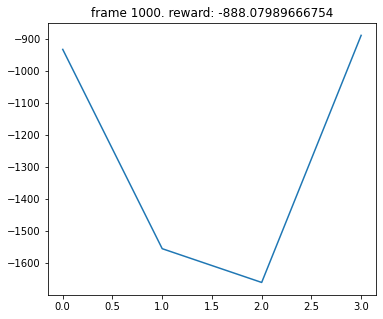

tensor([[-7.1374e+01],
        [-5.2872e+01],
        [-2.6923e+01],
        [-2.4973e+00],
        [-7.8541e+01],
        [-5.1438e+01],
        [-1.5747e+01],
        [-5.6514e+00],
        [-4.5523e+00],
        [-7.6822e+01],
        [-4.1705e+01],
        [-2.7184e+01],
        [-5.0630e+01],
        [-5.8082e+01],
        [-5.6191e+01],
        [-3.3425e+00],
        [-8.3865e+01],
        [-4.7206e+01],
        [-2.4245e+00],
        [-5.0318e+01],
        [-5.7761e-01],
        [-5.5627e+00],
        [-1.0767e+01],
        [-3.3609e+01],
        [-1.1404e+00],
        [-2.6121e+01],
        [-7.1241e+01],
        [-7.1789e-01],
        [-7.1598e+01],
        [-2.1563e+01],
        [-5.0633e+01],
        [-1.4996e+00],
        [-4.8357e+01],
        [-4.6289e+01],
        [-1.6823e+01],
        [-1.0762e+01],
        [-9.7196e+00],
        [-5.4238e+01],
        [-5.1453e+01],
        [-9.3111e+00],
        [-4.8949e+01],
        [-2.6496e+01],
        [-5.2345e+01],
        [-5

tensor([[-52.6055],
        [-34.4512],
        [ -9.2149],
        [ -5.2498],
        [-52.4026],
        [-18.4822],
        [ -3.8323],
        [-49.4552],
        [-50.5152],
        [-58.2004],
        [-54.8988],
        [-60.7280],
        [ -2.0241],
        [-39.3253],
        [-51.9246],
        [ -6.6386],
        [ -2.6624],
        [-62.2457],
        [-62.6524],
        [-48.3773],
        [-51.8219],
        [-47.0867],
        [-68.8233],
        [-58.3002],
        [-79.7681],
        [-51.9263],
        [-58.3570],
        [-80.1157],
        [-48.7581],
        [-33.2913],
        [-53.7998],
        [-56.2674],
        [-43.9706],
        [ -2.2016],
        [ -4.5019],
        [-77.9126],
        [-51.7826],
        [-51.9823],
        [-52.1948],
        [-50.7143],
        [-74.3919],
        [-52.8133],
        [-33.9992],
        [-55.7212],
        [-38.0611],
        [-43.6329],
        [ -2.3939],
        [-29.8739],
        [-10.2726],
        [-32.8011],


        [-49.7621]], grad_fn=<AddmmBackward0>) tensor([[ -7.3713],
        [-44.3333],
        [-45.8966],
        [-21.2033],
        [-59.5604],
        [-55.9964],
        [ -8.6783],
        [-48.4292],
        [-54.1164],
        [ -0.5841],
        [-74.2709],
        [-56.1905],
        [ -2.0706],
        [-53.4698],
        [-73.6874],
        [-55.3463],
        [-43.5631],
        [-24.9493],
        [-17.4643],
        [-66.8125],
        [-53.2924],
        [ -2.7994],
        [-15.8727],
        [ -0.8896],
        [-52.7968],
        [-52.6506],
        [-54.3433],
        [-23.8445],
        [-59.9608],
        [-82.3382],
        [-54.7150],
        [-39.0868],
        [ -1.9474],
        [-53.5458],
        [-34.6870],
        [-35.9877],
        [ -1.1850],
        [-56.6959],
        [-53.2077],
        [-44.4846],
        [-19.5482],
        [-47.9349],
        [-51.6850],
        [-54.2576],
        [-14.3701],
        [-53.0812],
        [-36.2814],
        [ -6.

tensor([[-47.0047],
        [-10.6297],
        [-45.1442],
        [-38.3867],
        [ -3.6856],
        [-61.0971],
        [-51.5432],
        [ -2.7820],
        [-53.9819],
        [-52.0408],
        [ -7.7692],
        [-55.3990],
        [-29.4726],
        [-61.4157],
        [-12.9848],
        [ -1.7208],
        [ -1.7631],
        [-50.6036],
        [ -1.2033],
        [ -4.0021],
        [ -2.1310],
        [ -8.6369],
        [ -5.8110],
        [ -3.9548],
        [-55.8597],
        [-39.9321],
        [ -3.8783],
        [-68.6394],
        [-37.6612],
        [-54.2987],
        [ -8.4426],
        [-51.1669],
        [-80.8964],
        [-44.7481],
        [-10.7159],
        [ -0.5513],
        [ -3.6242],
        [-82.7927],
        [-37.3360],
        [-54.9706],
        [-35.5870],
        [-54.3848],
        [-42.2238],
        [-17.8537],
        [-46.8827],
        [ -3.3570],
        [-53.2285],
        [ -3.3385],
        [-58.9070],
        [-26.9225],


tensor([[-57.7674],
        [ -4.7410],
        [ -8.6734],
        [ -7.8980],
        [-88.7497],
        [-18.4210],
        [ -3.0537],
        [-53.7750],
        [-26.4812],
        [-40.4874],
        [ -0.4201],
        [-41.6349],
        [ -6.2804],
        [-42.1071],
        [-13.7929],
        [-71.0400],
        [-53.9288],
        [-35.9166],
        [ -5.0793],
        [ -4.2690],
        [-56.9542],
        [ -7.0573],
        [-52.6399],
        [-80.9205],
        [-63.1567],
        [-55.7213],
        [ -1.9850],
        [-51.1566],
        [-59.8337],
        [-17.0501],
        [-57.9233],
        [ -1.1680],
        [-70.0059],
        [-38.6149],
        [-73.8695],
        [-60.9311],
        [-81.1764],
        [-48.0322],
        [-60.9741],
        [-52.6470],
        [ -4.7443],
        [-30.5293],
        [-55.6067],
        [-55.6640],
        [ -8.7567],
        [-64.5415],
        [-58.5577],
        [-11.1885],
        [-72.4624],
        [-13.2779],


tensor([[-2.5363e+01],
        [-6.4234e+00],
        [-7.7629e+00],
        [-5.7726e+01],
        [-3.8105e+01],
        [-3.5121e+01],
        [-9.0866e+01],
        [-5.4712e+01],
        [-5.0144e+01],
        [-4.1504e+00],
        [-4.8501e+01],
        [-5.6622e+01],
        [-4.3383e+01],
        [-3.0625e+01],
        [-9.2312e+00],
        [-5.7378e+01],
        [-5.7473e+01],
        [-8.8652e+00],
        [-7.2167e+00],
        [-8.3191e+01],
        [-1.9360e+01],
        [-7.6585e+00],
        [-1.4086e+01],
        [-6.1387e+01],
        [-3.5570e+01],
        [-6.0027e+01],
        [-4.5849e+01],
        [-8.4552e+01],
        [-7.8921e+01],
        [-1.2770e+01],
        [-8.4729e+01],
        [-4.4569e+01],
        [-9.2598e+01],
        [-4.5968e+01],
        [-5.8053e+01],
        [-2.6592e+01],
        [ 4.3975e-02],
        [-2.1510e+01],
        [-7.0176e+01],
        [-4.1927e+00],
        [-2.3788e+01],
        [-9.2164e+00],
        [-4.5710e+00],
        [-2

tensor([[ -2.3617],
        [-17.9522],
        [-68.3014],
        [-58.0468],
        [ -3.0945],
        [-89.5354],
        [ -5.6688],
        [-24.4576],
        [-38.6541],
        [ -1.1081],
        [ -3.2085],
        [ -4.1859],
        [-50.1131],
        [-27.3246],
        [ -1.2458],
        [-45.8457],
        [-23.1840],
        [-58.1853],
        [-53.8577],
        [-40.0264],
        [-67.4707],
        [-47.5118],
        [-49.2588],
        [-38.2462],
        [ -2.0523],
        [-40.0474],
        [-57.2251],
        [-45.9981],
        [-55.9889],
        [ -2.9928],
        [-56.8305],
        [-56.7618],
        [-15.8938],
        [ -3.9615],
        [-89.8322],
        [-19.3109],
        [ -3.7747],
        [-60.0878],
        [-66.8288],
        [-87.9942],
        [-14.1100],
        [-11.1644],
        [-39.6471],
        [-81.7123],
        [ -8.3012],
        [-62.4228],
        [ -2.5614],
        [ -9.2447],
        [-48.9715],
        [-46.6029],


tensor([[-23.4583],
        [-74.7752],
        [-75.3815],
        [-33.2859],
        [ -7.2455],
        [ -2.1182],
        [-20.3232],
        [-62.6287],
        [-46.3852],
        [ -3.1080],
        [-53.4796],
        [-46.8129],
        [ -7.3462],
        [-86.0020],
        [-57.2073],
        [-10.6328],
        [-10.7524],
        [-66.2357],
        [-44.4823],
        [-51.7004],
        [ -3.6218],
        [ -2.1343],
        [-85.2604],
        [-60.1216],
        [-23.0062],
        [ -2.8085],
        [-62.3438],
        [-59.4357],
        [-52.9513],
        [-87.1073],
        [-50.9417],
        [-39.4457],
        [-39.0259],
        [-67.8606],
        [-63.8973],
        [-58.9407],
        [-15.9145],
        [-51.4370],
        [-53.6389],
        [-26.6896],
        [-46.0593],
        [-90.6377],
        [-58.4786],
        [-58.2779],
        [ -6.6699],
        [-55.4500],
        [-59.6656],
        [-57.7050],
        [-63.3878],
        [-38.9733],


tensor([[ -2.2472],
        [ -2.8785],
        [-76.4546],
        [-26.9322],
        [-77.7408],
        [ -4.5690],
        [-34.9240],
        [-63.3614],
        [-48.0672],
        [-69.6162],
        [-13.2786],
        [-60.3101],
        [-41.3731],
        [-61.3793],
        [-56.9806],
        [-31.1019],
        [-76.6984],
        [-17.6615],
        [ -7.0457],
        [-48.9521],
        [-58.9244],
        [-51.4547],
        [-59.6066],
        [-33.8610],
        [ -3.4613],
        [-25.9578],
        [-35.9378],
        [-65.8932],
        [-48.2668],
        [-47.4748],
        [-48.2805],
        [-60.4750],
        [-48.9754],
        [-80.5827],
        [-33.8225],
        [-34.3282],
        [ -1.7138],
        [-39.0607],
        [-65.2957],
        [-15.0580],
        [-50.7331],
        [-40.1015],
        [ -4.7967],
        [-42.3781],
        [-46.1785],
        [-62.2083],
        [-14.1425],
        [-48.8803],
        [-64.5321],
        [-89.1113],


tensor([[ -7.4156],
        [-60.9485],
        [-25.4917],
        [-52.1542],
        [-63.2062],
        [-61.6596],
        [-65.9366],
        [-62.3073],
        [-51.8444],
        [-79.1940],
        [-63.1277],
        [-60.7464],
        [-79.4466],
        [-58.0743],
        [-92.9822],
        [-61.8666],
        [-64.5504],
        [-20.2367],
        [-55.5685],
        [-24.9873],
        [-61.9977],
        [-56.0965],
        [-27.4829],
        [-59.8344],
        [-55.3139],
        [-68.4845],
        [-61.6137],
        [-90.8131],
        [-59.0013],
        [-20.2874],
        [-60.4281],
        [-64.7965],
        [-35.2933],
        [-78.5546],
        [-30.1013],
        [ -9.8934],
        [-67.9279],
        [ -5.3448],
        [-57.6266],
        [ -4.2970],
        [-51.8446],
        [-37.6992],
        [-42.4580],
        [-18.0838],
        [-62.9312],
        [ -8.2908],
        [-63.1697],
        [-59.0998],
        [ -7.7134],
        [ -3.5230],


tensor([[-60.0639],
        [-42.4401],
        [-61.7304],
        [-53.8884],
        [-62.8838],
        [-80.3468],
        [-62.0281],
        [ -1.5830],
        [-19.7788],
        [ -4.7350],
        [-62.5724],
        [-46.4258],
        [ -5.8421],
        [-16.5026],
        [-64.2820],
        [-63.4282],
        [-72.3792],
        [ -1.4209],
        [-50.3093],
        [-63.3380],
        [-17.3946],
        [-25.4783],
        [-86.0454],
        [-40.7508],
        [-58.2906],
        [-54.6337],
        [-60.6178],
        [-98.0351],
        [-65.9988],
        [-83.0998],
        [-44.2320],
        [-48.7254],
        [-32.5047],
        [-27.9977],
        [-44.3898],
        [ -4.0561],
        [-10.1033],
        [-60.4185],
        [ -9.2888],
        [-57.5644],
        [-63.8044],
        [-17.9245],
        [-38.4190],
        [-10.0149],
        [-15.3668],
        [-63.6746],
        [-62.2778],
        [-90.0887],
        [ -5.3122],
        [ -2.3167],


tensor([[-70.1965],
        [-55.8609],
        [-12.6968],
        [-41.9748],
        [-64.0326],
        [-26.6013],
        [-64.2163],
        [-62.2471],
        [-64.0102],
        [-30.8247],
        [ -9.0939],
        [ -3.9070],
        [ -6.6750],
        [-60.9583],
        [-23.2561],
        [ -6.6038],
        [-22.7851],
        [-87.3817],
        [ -5.0406],
        [-64.7494],
        [-13.3372],
        [-74.5493],
        [ -5.8271],
        [-71.0760],
        [-64.3269],
        [-76.0089],
        [-12.2891],
        [-35.8645],
        [ -2.1974],
        [-67.9428],
        [ -6.8497],
        [-62.0236],
        [ -4.9255],
        [-63.5290],
        [-91.1500],
        [-55.0176],
        [-38.2543],
        [-46.2925],
        [-32.3246],
        [-30.0504],
        [-86.5967],
        [-42.5915],
        [-64.7377],
        [ -2.0839],
        [-37.1040],
        [-61.3149],
        [-52.3974],
        [-66.2578],
        [-52.4468],
        [-21.7843],


tensor([[-88.1657],
        [-61.3684],
        [-63.7450],
        [-63.8249],
        [ -5.5232],
        [-61.3959],
        [-64.9505],
        [-37.9977],
        [ -3.8633],
        [-64.4211],
        [-63.9720],
        [ -8.6882],
        [ -8.4593],
        [ -1.8367],
        [ -3.9063],
        [ -4.6019],
        [-58.0848],
        [-63.3912],
        [ -5.5470],
        [-62.9630],
        [-82.0758],
        [-54.3535],
        [-51.8056],
        [-57.0901],
        [-64.1902],
        [-50.5324],
        [-64.5689],
        [-60.5995],
        [-62.6451],
        [-81.2564],
        [-11.5734],
        [-62.1860],
        [-64.6027],
        [-62.6398],
        [-45.0538],
        [ -8.4243],
        [ -8.0004],
        [-18.6555],
        [-70.4453],
        [-64.5791],
        [-57.2971],
        [-60.7422],
        [-47.5214],
        [ -5.9062],
        [-32.1746],
        [-63.0781],
        [-68.3717],
        [ -6.8985],
        [ -1.2903],
        [-63.1150],


        [-47.9488]], grad_fn=<AddmmBackward0>) tensor([[-94.2348],
        [ -2.6610],
        [-53.5167],
        [-50.1952],
        [-17.2114],
        [-66.9111],
        [ -3.4411],
        [-83.9096],
        [-49.4211],
        [-62.3593],
        [ -8.7749],
        [-33.4542],
        [-50.5944],
        [-29.6892],
        [-48.9720],
        [ -7.4155],
        [-68.6449],
        [-60.6957],
        [-45.2320],
        [ -5.8542],
        [ -3.3981],
        [-54.2228],
        [-63.3588],
        [-16.1445],
        [-66.1550],
        [ -2.7866],
        [-58.6690],
        [-67.3627],
        [-63.2610],
        [-89.7170],
        [-66.8433],
        [-57.4652],
        [-90.9104],
        [-65.4430],
        [-61.6305],
        [-59.3420],
        [-50.1097],
        [-51.0827],
        [-89.8757],
        [-81.1337],
        [-61.7886],
        [-60.3066],
        [-59.1008],
        [-65.0700],
        [-32.4981],
        [-18.9241],
        [-54.7838],
        [-65.

tensor([[-22.5862],
        [-81.4416],
        [ -6.4177],
        [-59.7654],
        [-67.1562],
        [-66.8927],
        [-21.4983],
        [ -1.3428],
        [-83.9100],
        [ -6.4101],
        [-16.6872],
        [-69.6536],
        [ -2.6631],
        [-66.1128],
        [-64.5866],
        [-56.5170],
        [-44.9332],
        [-12.5838],
        [-67.1138],
        [-79.5264],
        [-73.7043],
        [-16.5265],
        [ -1.7263],
        [-63.3126],
        [ -4.5270],
        [-41.3636],
        [-67.9177],
        [-50.3578],
        [-27.2414],
        [ -3.6765],
        [-62.8449],
        [-11.9475],
        [ -5.5394],
        [-96.4814],
        [-67.2865],
        [-53.4183],
        [-68.8561],
        [ -1.8182],
        [-24.7769],
        [-40.3227],
        [-51.7438],
        [ -3.3199],
        [-77.6765],
        [ -2.8238],
        [-65.3882],
        [ -7.7209],
        [-65.8166],
        [-14.3788],
        [-47.0984],
        [-60.3438],


tensor([[ -3.8937],
        [-67.9143],
        [-94.7557],
        [-64.6924],
        [ -3.1735],
        [-75.9520],
        [-51.1093],
        [-84.5076],
        [-67.7572],
        [-67.0617],
        [-90.4997],
        [-13.8576],
        [-78.1736],
        [ -1.4444],
        [-49.0824],
        [-54.2457],
        [-70.8415],
        [-62.0012],
        [ -5.6511],
        [ -6.2088],
        [-11.0498],
        [-69.8540],
        [-71.1920],
        [-67.0697],
        [-73.1383],
        [ -7.4263],
        [-74.0724],
        [-62.8113],
        [-10.6239],
        [ -6.9317],
        [-68.0242],
        [-90.7181],
        [-83.5737],
        [ -9.0666],
        [-95.5165],
        [-60.1648],
        [-21.0149],
        [-69.7346],
        [-64.1879],
        [-11.0121],
        [-71.9946],
        [-70.5230],
        [-44.8092],
        [-78.7596],
        [ -3.3035],
        [-59.2522],
        [-69.0171],
        [-23.9226],
        [-65.7259],
        [-69.1418],


tensor([[-35.7971],
        [-66.7688],
        [ -3.7956],
        [-67.8692],
        [-68.7599],
        [ -8.9302],
        [-98.0096],
        [-12.1150],
        [-41.5598],
        [-61.0504],
        [ -4.6852],
        [-57.4595],
        [-64.5803],
        [-16.5817],
        [-69.8512],
        [-64.4404],
        [-25.2582],
        [-69.7415],
        [-73.2207],
        [-35.7990],
        [-66.1017],
        [-44.2831],
        [-23.5828],
        [ -3.7141],
        [-44.9558],
        [-31.7712],
        [-49.7753],
        [-69.2147],
        [-76.7849],
        [-68.9342],
        [ -4.3082],
        [-80.9187],
        [-64.5375],
        [-23.6252],
        [-67.8210],
        [-68.9215],
        [-15.1736],
        [-54.5913],
        [ -8.9511],
        [-65.7542],
        [-62.9280],
        [-79.4523],
        [ -7.5582],
        [-68.2048],
        [-69.7510],
        [-82.5305],
        [-21.9285],
        [-67.0759],
        [-58.6915],
        [-56.5744],


tensor([[-70.7265],
        [-14.3876],
        [-71.6115],
        [-71.9514],
        [-51.0328],
        [-66.0364],
        [-73.9140],
        [-60.6284],
        [-12.5670],
        [-86.8654],
        [-70.8169],
        [ -1.8262],
        [-90.4369],
        [-26.5497],
        [-51.1877],
        [-73.0645],
        [-28.9192],
        [-65.1351],
        [-64.3588],
        [-69.9614],
        [-67.1482],
        [-58.1995],
        [ -6.5598],
        [-69.3918],
        [ -5.0156],
        [-71.0024],
        [-76.3030],
        [ -3.8216],
        [-67.6742],
        [-69.1807],
        [-63.8601],
        [-54.3668],
        [ -5.0760],
        [-37.2447],
        [-69.9072],
        [-68.3123],
        [-51.8908],
        [-62.3151],
        [-12.6288],
        [-40.4228],
        [-70.9125],
        [-27.6837],
        [-64.0185],
        [-67.4040],
        [-18.9258],
        [-62.7464],
        [-77.4915],
        [-97.4372],
        [-68.0058],
        [ -2.2517],


tensor([[ -73.2879],
        [ -29.9665],
        [ -71.9536],
        [ -71.9875],
        [ -74.0559],
        [ -19.7035],
        [ -67.2506],
        [ -69.8776],
        [ -96.2991],
        [ -72.5118],
        [ -15.8190],
        [ -69.9855],
        [ -52.4584],
        [ -72.0074],
        [ -59.4298],
        [ -63.2640],
        [ -60.8503],
        [ -27.9354],
        [ -24.1893],
        [ -66.7537],
        [ -71.1218],
        [ -27.5285],
        [ -70.8617],
        [ -19.5191],
        [ -63.3033],
        [ -72.7621],
        [  -4.4208],
        [ -13.6103],
        [  -7.1352],
        [ -44.5056],
        [ -83.6202],
        [ -63.7155],
        [  -3.5143],
        [ -78.1134],
        [ -69.2940],
        [  -7.7291],
        [-103.0710],
        [  -5.5538],
        [ -62.6062],
        [ -76.4502],
        [ -36.2873],
        [ -71.3485],
        [  -6.0170],
        [ -70.8588],
        [ -53.2124],
        [ -62.4925],
        [ -63.0030],
        [ -60

tensor([[ -75.6991],
        [ -74.7387],
        [ -71.4528],
        [ -78.5932],
        [ -30.0564],
        [  -9.3325],
        [ -73.6735],
        [ -62.4773],
        [ -39.7235],
        [ -67.7862],
        [ -40.7139],
        [ -98.3362],
        [ -25.8302],
        [ -78.7052],
        [ -73.5241],
        [ -71.8640],
        [ -66.5961],
        [ -94.7242],
        [ -94.2099],
        [ -70.8096],
        [  -4.5086],
        [ -72.5463],
        [ -73.0005],
        [ -87.5469],
        [  -3.1854],
        [ -61.3978],
        [ -66.4095],
        [ -65.9525],
        [ -39.4423],
        [ -63.9610],
        [ -13.6313],
        [ -26.0032],
        [  -5.1121],
        [  -5.6502],
        [ -70.1522],
        [ -70.7527],
        [ -56.4728],
        [ -49.0739],
        [  -5.2300],
        [ -73.5462],
        [ -71.7022],
        [ -61.8507],
        [ -70.4753],
        [ -66.5947],
        [ -68.4974],
        [ -34.0152],
        [ -72.4663],
        [ -72

tensor([[-98.8360],
        [-41.7535],
        [-52.7077],
        [ -5.3072],
        [-73.0633],
        [ -2.5093],
        [-67.7652],
        [-68.3262],
        [-94.0337],
        [-61.8098],
        [-62.3145],
        [-32.6787],
        [ -3.3990],
        [-63.8521],
        [-73.5760],
        [-77.5584],
        [ -3.9330],
        [-72.3451],
        [-71.5509],
        [-68.0227],
        [-68.5432],
        [-61.5123],
        [-58.1126],
        [-97.0063],
        [-72.5119],
        [ -4.7061],
        [-73.7384],
        [-74.4373],
        [-75.7491],
        [ -8.9034],
        [-72.4910],
        [-29.3207],
        [-72.4526],
        [-80.8492],
        [-76.7581],
        [ -4.8784],
        [ -9.1880],
        [-21.2233],
        [-25.9565],
        [-95.9014],
        [-71.7192],
        [-71.9159],
        [-95.0915],
        [-67.0189],
        [-70.3755],
        [-98.0526],
        [-76.5075],
        [-68.3583],
        [-95.5544],
        [-61.3903],


KeyboardInterrupt: 

In [61]:
%matplotlib inline
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_net.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
#         print(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
            
#         time.sleep(.1)
        
    rewards.append(episode_reward)

<h2> Visualize Trained Algorithm </h2> - <a href="http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html">source</a>  

In [40]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5000000)
    display(anim)

<IPython.core.display.Javascript object>


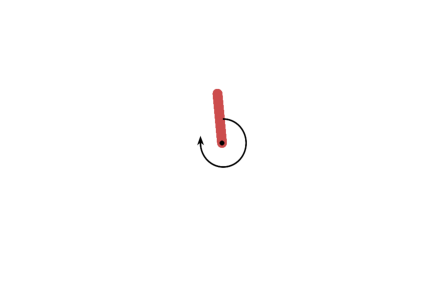

In [52]:
env = gym.make("Pendulum-v1")
%matplotlib notebook

# Run a demo of the environment
state = env.reset()
cum_reward = 0
frames = []
for t in range(50000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = policy_net.get_action(state)
    state, reward, done, info = env.step(action.detach())
    if done:
        break
env.close()
display_frames_as_gif(frames)

